In [ ]:
# Google Colab compatibility
from google.colab import drive
drive.mount('/content/drive')
!pip install opendatasets

Mounted at /content/drive


In [ ]:

# Import Libraries
import opendatasets as od
import os
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2





# Data Preprocessing and Exploration

In [ ]:
# Download path
download_path = '/content/drive/MyDrive/Colab Notebooks/Computer_Vision_Project'
os.chdir(download_path)

# # Load dataset from Kaggle
# od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification",
#             data_dir=download_path)

# # Define the path to the main images folder
# image_folder = './recyclable-and-household-waste-classification/images/images'

# # Traverse the subdirectories and list images
# image_paths = []
# for root, dirs, files in os.walk(image_folder):
#     for file in files:
#         # Append full path for each image file
#         image_paths.append(os.path.join(root, file))




In [ ]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_1.png


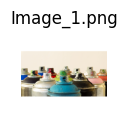

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_10.png


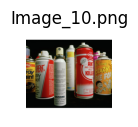

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_100.png


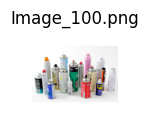

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_101.png


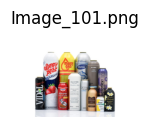

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_102.png


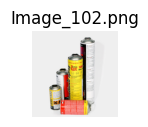

In [ ]:
# Display a few sample images
for i, image_path in enumerate(image_paths[:5]):  # Show the first 5 images
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [ ]:
# Define paths
dataset_dir = './recyclable-and-household-waste-classification/images/images'
train_dir = './split_dataset/train/images'
test_dir = './split_dataset/test/images'
validation_dir = './split_dataset/validation/images'

# Ensure train and test directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Initialize counters
train_count = 0
test_count = 0
validation_count = 0

# Process each class in the dataset directory
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        # Create class folders in train, test, validation directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)


        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/10/10 train, val, test sets
        random.shuffle(images)
        train_split_idx = int(len(images) * 0.8)
        validation_split_idx = int(len(images) * 0.9)
        train_images = images[:train_split_idx]
        validation_images = images[train_split_idx:validation_split_idx]
        test_images = images[validation_split_idx:]

        # Copy images to train, val, test directories
        for image_path in train_images:
            subfolder_name = os.path.basename(os.path.dirname(image_path))
            unique_name = f"{subfolder_name}_{os.path.basename(image_path)}"
            dest_path = os.path.join(train_dir, class_name, unique_name)
            shutil.copyfile(image_path, dest_path)
            train_count += 1

        for image_path in validation_images:
            subfolder_name = os.path.basename(os.path.dirname(image_path))
            unique_name = f"{subfolder_name}_{os.path.basename(image_path)}"
            dest_path = os.path.join(validation_dir, class_name, unique_name)
            shutil.copyfile(image_path, dest_path)
            validation_count += 1

        for image_path in test_images:
            subfolder_name = os.path.basename(os.path.dirname(image_path))
            unique_name = f"{subfolder_name}_{os.path.basename(image_path)}"
            dest_path = os.path.join(test_dir, class_name, unique_name)
            shutil.copyfile(image_path, dest_path)
            test_count += 1

# Print total counts
print(f"Dataset successfully split into train, validation, test folders!")
print(f"Total train images: {train_count}")
print(f"Total validation images: {validation_count}")
print(f"Total test images: {test_count}")


Dataset successfully split into train, validation, test folders!
Total train images: 12000
Total validation images: 1500
Total test images: 1500


In [ ]:
from PIL import Image
import os

def check_images(directory):
    invalid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()  # Verify image integrity
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return invalid_images

invalid_train = check_images(train_dir)
invalid_test = check_images(test_dir)
invalid_val = check_images(validation_dir)

print(f"Invalid train images: {len(invalid_train)}")
print(f"Invalid test images: {len(invalid_test)}")
print(f"Invalid validation images: {len(invalid_val)}")


Invalid train images: 0
Invalid test images: 0
Invalid validation images: 0


In [ ]:
# Function to count files in a directory (recursively)
def count_files_in_directory(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Count files in train, val, test directories
total_train_files = count_files_in_directory(train_dir)
total_validation_files = count_files_in_directory(validation_dir)
total_test_files = count_files_in_directory(test_dir)

# Print the counts
print(f"Total files in train directory: {total_train_files}")
print(f"Total files in validation directory: {total_validation_files}")
print(f"Total files in test directory: {total_test_files}")

Total files in train directory: 12000
Total files in validation directory: 1500
Total files in test directory: 1500


In [29]:
def create_dataset(directory, batch_size, augment=False, shuffle=True, seed=None):
    # Load dataset (images and labels are already tensors)
    raw_dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed
    )

    # Extract class names
    class_names = raw_dataset.class_names

    # Define preprocessing and augmentation
    random_rotation_layer = RandomRotation(factor=0.1) # Rotate 10% of 360 deg
    def preprocess_and_augment(image, label, seed=42):
        # Set global seed for reproducibilty
        tf.random.set_seed(seed)

        # Normalize pixel values to [0, 1]
        image = tf.cast(image, tf.float32) / 255.0
        if augment:
            image = tf_image.random_flip_left_right(image, seed=seed)  # Horizontal flip
            image = tf_image.random_brightness(image, 0.2)  # Random brightness
            image = tf_image.random_contrast(image, 0.8, 1.2)  # Random contrast

        # Ensure image size is consistent after augmentations
        image = tf.image.resize(image, [224, 224])

        return image, label

    # Apply preprocessing (and augmentation if specified)
    processed_dataset = raw_dataset.map(
        preprocess_and_augment,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Prefetch for performance
    processed_dataset = processed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return processed_dataset, class_names


In [30]:
train_dir = './split_dataset/train/images'
test_dir = './split_dataset/test/images'
validation_dir = './split_dataset/validation/images'

# Parameters
batch_size = 32

# Create training dataset with augmentation
train_dataset, train_class_names = create_dataset(
    train_dir,
    batch_size=batch_size,
    augment=True,
    shuffle=True,
    seed=42
)

# Create validation dataset without augmentation
val_dataset, val_class_names = create_dataset(
    validation_dir,
    batch_size=batch_size,
    augment=False,
    shuffle=False
)

# Create test dataset without augmentation
test_dataset, test_class_names = create_dataset(
    test_dir,
    batch_size=batch_size,
    augment=False,
    shuffle=False
)

Found 12000 files belonging to 30 classes.
Found 1500 files belonging to 30 classes.
Found 1500 files belonging to 30 classes.


In [12]:
# Verify dataset compatibility for model
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Labels shape: {labels.shape}")  # Should be (batch_size,)
    print(f"Sample labels: {labels.numpy()}")  # Should display integers


Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Sample labels: [23  4 21 21 20  8 20 28 17 26  4 22  0 28  8 11 29  3  4 13 14  5  0 18
  1  2 11  7  1 29  8  5]


# Tranfer Learning with VGG16 model

In [13]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("No GPU found, using CPU.")

print(f"Number of CPU cores: {os.cpu_count()}")

# Load VGG16 without the top layers to prepare for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to retain the pre-trained weights
base_model.trainable = False



Using GPU: /device:GPU:0
Number of CPU cores: 12
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
#Enable mixed precision
set_global_policy('mixed_float16')

# Build model
model = Sequential([
    base_model,
    Flatten(),

    #First layer
    Dense(1024, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second layer
    Dense(512, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Third layer
    Dense(256, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    #Fourth layer
    Dense(128, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    # #Fifth layer
    # Dense(128, kernel_regularizer=l2(0.0005)),
    # BatchNormalization(),
    # Activation('relu'),

    # Output layer (logits are in float32)
    Dense(30, activation='softmax', dtype='float32')
])

# Use learning rate scheduler to adjust dynamically
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1125, # Update about every 3 epochs
    decay_rate=0.9
)

# Define optimizer with lr scheduler, weight decay, and gradient clipping
optimizer = AdamW(
    learning_rate=lr_schedule,
    clipnorm=1.0,
    weight_decay=0.0001
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 41,106,398 (156.81 MB)

 Trainable params: 26,387,870 (100.66 MB)

 Non-trainable params: 14,718,528 (56.15 MB)

In [21]:
# Implement ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',          # Filepath to save the model
    monitor='val_loss',       # Metric to monitor
    save_best_only=True,      # Save only the best model based on val_loss
    mode='min',               # Save when val_loss decreases
    verbose=1                 # Print progress messages
)

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop if no improvement for 5 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1057 - loss: 4.8990
Epoch 1: val_loss improved from inf to 3.49696, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.1061 - loss: 4.8972 - val_accuracy: 0.5087 - val_loss: 3.4970
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3672 - loss: 3.8222
Epoch 2: val_loss improved from 3.49696 to 3.01402, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.3672 - loss: 3.8219 - val_accuracy: 0.6160 - val_loss: 3.0140
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4922 - loss: 3.3140
Epoch 3: val_loss improved from 3.01402 to 2.63712, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.4923 - loss: 3.3138 - val_accuracy: 0.6820 - val_loss: 2.6371
Epoch 4/30
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5730 - loss: 2.9387
Epoch 4: val_loss improved from 2.63712 to 2

In [23]:
history_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    initial_epoch=30,
    callbacks=[checkpoint, early_stopping]
)

Epoch 31/40
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9302 - loss: 0.9768
Epoch 31: val_loss did not improve from 1.40300
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9302 - loss: 0.9767 - val_accuracy: 0.8347 - val_loss: 1.4135
Epoch 32/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9382 - loss: 0.9528
Epoch 32: val_loss did not improve from 1.40300
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9382 - loss: 0.9527 - val_accuracy: 0.8293 - val_loss: 1.4116
Epoch 33/40
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9427 - loss: 0.9296
Epoch 33: val_loss improved from 1.40300 to 1.39919, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9427 - loss: 0.9296 - val_accuracy: 0.8333 - val_loss: 1.3992
Epoch 34/40
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9383 - loss: 0.9239
Epoch 34: val_loss improved from 1.39919 to 1.36854, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━

# Evaluation

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7907 - loss: 1.5013
Test Loss: 1.4363247156143188
Test Accuracy: 0.8173333406448364


In [26]:
# Combine loss and accuracy data from the two training sessions
training_loss = history.history['loss'] + history_2.history['loss']
val_loss = history.history['val_loss'] + history_2.history['val_loss']
training_accuracy = history.history['accuracy'] + history_2.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history_2.history['val_accuracy']

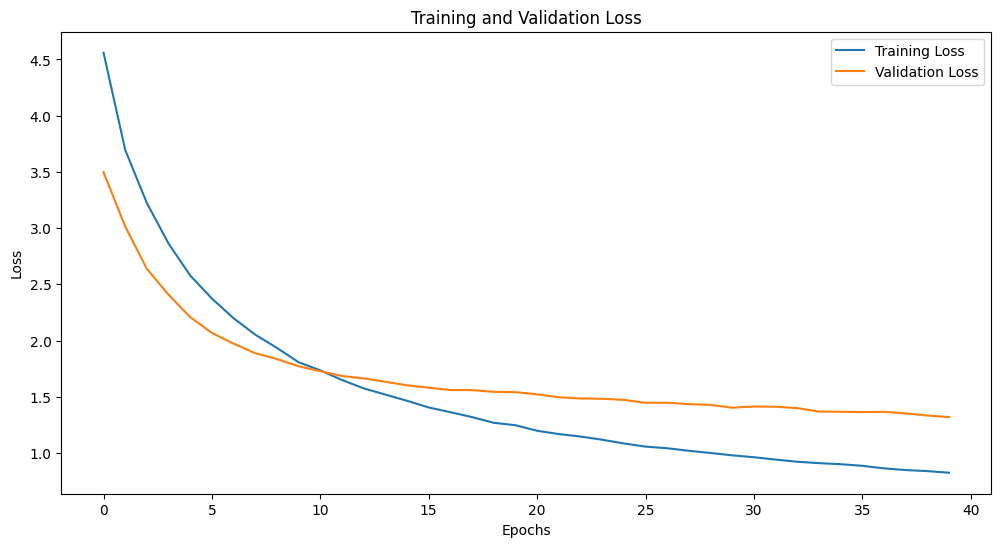

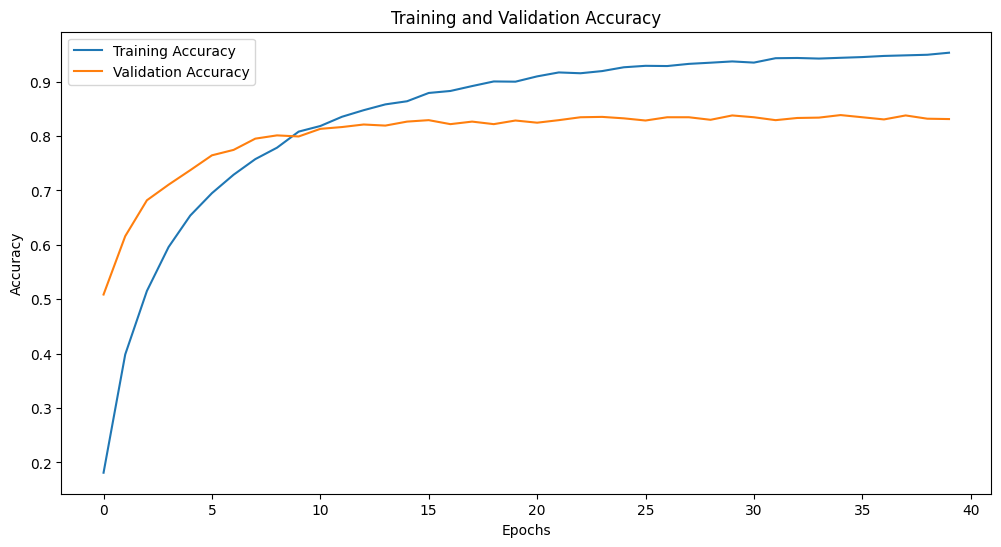

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
# Predict on the test dataset
y_pred_probs = model.predict(test_dataset)  # Model outputs probabilities
y_pred = np.argmax(y_pred_probs, axis=1)    # Convert probabilities to class labels

# Extract true labels from the test dataset
y_true = np.concatenate([label.numpy() for _, label in test_dataset], axis=0)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


Precision: 0.82
Recall: 0.82
F1-Score: 0.82

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.86      0.86      0.86        50
        aluminum_food_cans       0.58      0.56      0.57        50
        aluminum_soda_cans       0.78      0.90      0.83        50
           cardboard_boxes       0.60      0.60      0.60        50
       cardboard_packaging       0.59      0.52      0.55        50
                  clothing       0.83      0.78      0.80        50
            coffee_grounds       0.88      0.86      0.87        50
disposable_plastic_cutlery       0.96      0.96      0.96        50
                 eggshells       0.80      0.88      0.84        50
                food_waste       0.88      0.86      0.87        50
    glass_beverage_bottles       0.91      0.80      0.85        50
 glass_cosmetic_containers       0.84      0.94      0.89        50
           glass_food_jars       0.90      0.92

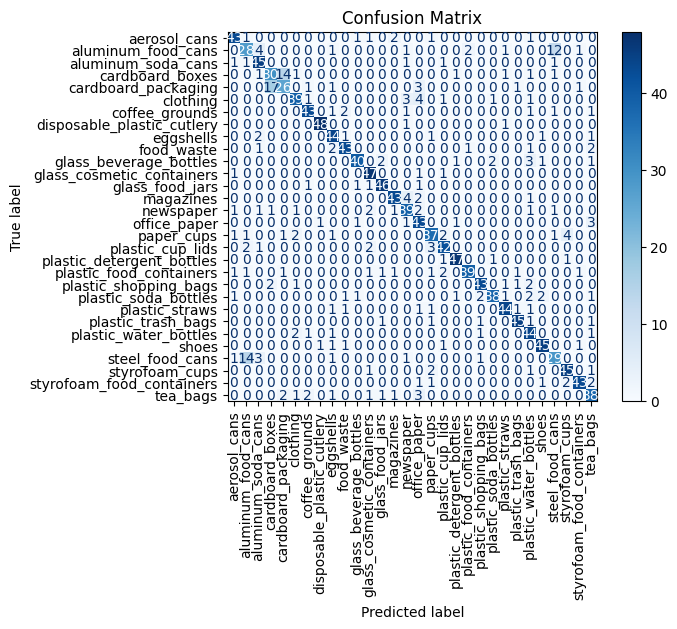

In [34]:
# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=test_class_names)
print("\nClassification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()